# Create a Video from a Script and Images

This notebook pulls data from an Excel file containing a list of influential figures. It is able to convert text into speech and then combine this with images to produce a video ready for YouTube. The section at the end also allows the user to create a thumbnail for the video and produces a description from a template.

The scripts have been generated using ChatGPT with the prompt "Generate 10 pretty long and interesting facts about \<Influential Figure>". If a script is generated but no audio available then the code will create an audio file based on the script and a pre-made intro and outro. The user must add picutres to a folder of the figure and if they are available but no video produced then the code will calculate a duration for all images and create a video from these images and the audio clip.

Once that is done the video will be saved to the Videos folder but a copy will be in the main repository for ease when uploading to YouTube. You then can make a thumbnail out of images in the respective figures Images file or a seperate image before adding text to the image to make it stand out. A description is also returned for easy uploading.

## Load modules

In [1]:
import pandas as pd
import numpy as np
import os # Check folder contents
import docx2txt # Import word files
import openpyxl # Save files to Excel
import random # For thumbnail
from PIL import Image, ImageFont, ImageDraw # Resizing thumbnail and adding text

## Load/Prepare Data Files

### Set Locations

Here we set all of the locations for the data as well as loading in the pre-made Intro, Description, and Outro.

In [43]:
script_loc = "./Scripts/"
images_loc = "./Images/"
set_scripts_loc = "./Set Scripts/"
audio_loc = "./Audio/"
video_loc = "./Video/"

# Get the Intro
intro = docx2txt.process(set_scripts_loc + 'Intro.docx')

# Get the Description
description = docx2txt.process(set_scripts_loc + 'Description.docx')

# Get the Outro
outro = docx2txt.process(set_scripts_loc + 'Outro.docx')

### Load the dataframe of information

Here we load in the dataframe containing the information on the influential figures before adding the prompt and making sure we have no duplicates in the names. We the overwrite the file.

In [3]:
historical_figures_list = pd.read_excel(r'Historical Figures List.xlsx')

In [4]:
# Create the ChatGPT prompt
historical_figures_list['Prompt'] = "Generate 10 pretty long and interesting facts about " + historical_figures_list['Name']
# Remove duplicate names
historical_figures_list = historical_figures_list.drop_duplicates(subset = ['Name'])

historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)

## Create Any Necessary Audio Files

This code checks if there are any figures who have a script saved but no audio. If there isn't any audio then the code creates some and saves it to the Audio folder with the figures name as the file name. It then updates the Excel file to show that the audio has been saved.

In [5]:
# Here we want to capture any figures who need audio. We can create this in one loop.
need_audio = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "No")]

In [6]:
# We only do this if audio is needed
if need_audio.shape[0] > 0:
    # These library only needed here
    import pyttsx3 # Text to speech
  
    # Initialise the engine and set some parameters
    engine = pyttsx3.init()

    # Set the voice
    engine.setProperty('voice',
                       'HKEY_LOCAL_MACHINE\SOFTWARE\Microsoft\Speech\Voices\Tokens\TTS_MS_EN-US_ZIRA_11.0')
  
    # Set the talking rate
    rate = engine.getProperty('rate')
    engine.setProperty('rate', rate-50)

    # Create figure filepaths
    figure_scripts = list(need_audio.iloc[:,1].values + '.docx')

    # Now want to loop through the figures, getting the script, the figures name and then
    # saving the audio before changing the value in the Excel file for needs audio to yes.
    for figure in figure_scripts:
    
        # Grab the script
        my_text = docx2txt.process(script_loc + figure)
    
        # Alter the script
        my_text = intro + my_text + outro 
    
        # Return the figure's name
        figure_name = os.path.splitext(figure)[0]
    
        # Create the audio location
        audio_script_loc = audio_loc + figure_name + ".mp3" 
    
        # Save the file
        engine.save_to_file(my_text, audio_script_loc)
    
        # Convert the No to Yes in needs audio column
        historical_figures_list.iloc[(historical_figures_list.Name == figure_name),4] = "Yes"
    
        # Once all done stop the engine and then overwrite the Excel file
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
        
    engine.runAndWait()
    engine.stop()
  

## COMMENT OUT - THIS IS FOR MAC WILL ADJUST WHEN ABLE

In [7]:
#import gtts # Speech to text
# make request to google to get synthesis
#tts = gtts.gTTS(my_text, tld= "co.uk")
# save the audio file
#tts.save("hello.mp3")

In [8]:
# play the audio file
# playsound("hello.mp3")

## Check For Images

Next we want to check to see if there are any figures who have images in the Images folder but i have forgot to change the images value to yes

In [9]:
# We grab any that still need images
need_images = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                      (historical_figures_list.AI_Voice_Generated == "Yes") &
                                      (historical_figures_list.Images_Obtained == "No")]

In [10]:
# If there are figures with images needed we will check to see if there are actually images there and then if there
# are we will change the images obtained value to yes.
if need_images.shape[0] > 0:
    
    # List all of the figures needing images
    figures_image = list(need_images.iloc[:,1].values)
    
    for figure in figures_image:
        # Create the filepath
        image_path = images_loc + '/' + figure
        
        # If there are any figures where the folder path exists
        if os.path.exists(image_path) == True:
            # Check the number of files and if more than zero. Make changes to document
            if len(os.listdir(image_path + '/')) > 0:
                historical_figures_list.iloc[(historical_figures_list.Name == figure),5] = "Yes"
                historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)
                

## Add Video

Next we wish to check if any figures have a script, an audio and images available but there is no video recorded. If this is the case then the code will loop through the figures and combine the audio and images together to create a vide and save it in the Video folder before finally adjusting the table to show this.

In [11]:
# We will grab any figures who have a script and audio complete but no video.
need_video = historical_figures_list[(historical_figures_list.Script_Created == "Yes") &
                                     (historical_figures_list.AI_Voice_Generated == "Yes") &
                                     (historical_figures_list.Images_Obtained == "Yes") &
                                     (historical_figures_list.Youtube_Video_Created == "No")]

In [12]:
if need_video.shape[0] > 0:
    from moviepy.editor import *
    os.environ["IMAGEIO_FFMPEG_EXE"] = "ffmpeg"
    figure_video = list(need_video.iloc[:,1].values)
    
    for figure in figure_video:
        audio_location = audio_loc + figure + '.mp3'
        image_location = images_loc + figure + '/'
        video_location = video_loc + figure + '.mp4'
        
        audio_clip = AudioFileClip(audio_location)
        audio_duration = audio_clip.duration
        
        number_of_images = len(os.listdir(image_location))
        image_duration = audio_duration / number_of_images
        
        img_names = os.listdir(image_location)

        img = list(image_location + img for img in img_names)

        clips = [ImageClip(m).set_duration(image_duration)
                 for m in img]

        concat_clip = concatenate_videoclips(clips, method="compose")
        
        concat_clip.write_videofile("test.mp4", fps = 24)
        
        video_clip = VideoFileClip("test.mp4")
        
        video_clip.audio = audio_clip
        
        video_clip.write_videofile(video_location)
        
        os.remove("test.mp4")
        
        historical_figures_list.iloc[(historical_figures_list.Name == figure),6] = "Yes"
        historical_figures_list.to_excel('Historical Figures List.xlsx', index=False)

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4
Moviepy - Building video ./Video/Nelson Mandela.mp4.
MoviePy - Writing audio in Nelson MandelaTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video ./Video/Nelson Mandela.mp4



Moviepy - Done !
Moviepy - video ready ./Video/Nelson Mandela.mp4


## Create Description For Upload

In [41]:
def create_description(string, string_to_replace, figure):
    # Create YouTube description
    modified_string = string.replace(string_to_replace, figure)
    print(modified_string)

In [14]:
def move_video(figure):
    # We want to move the video to the main file directory
    import shutil
    video_location = video_loc + figure + '.mp4'
    shutil.copy2(video_location, "video.mp4")

In [15]:
def create_thumbnail(figure):

    # Set image location
    image_location = images_loc + figure + '/'

    # Return images
    img_names = os.listdir(image_location)
    
    # Select an image at random
    selected_image = image_location + random.choice(img_names)
   
    # This plots the thumbnail so we can see it
    %matplotlib inline
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    img = mpimg.imread(selected_image)
    imgplot = plt.imshow(img)
    plt.show()
    
    # Now we want to convert the thumbnail into a resized thumbnail.

    # Open the image
    image = Image.open(selected_image)

    # 1280 × 720 pixels - thumbnail size
    max_image_size = (1280, 720)

    # Set the image size to the max
    image.thumbnail(max_image_size)
  
    # creating thumbnail
    image.save('thumbnail.png')

## Youtube Preparation

In [23]:
move_video('Nelson Mandela')

In [44]:
create_description(description, "[Historical Figure]", 'Nelson Mandela')

Welcome to Figures in History! In this episode, we delve into the life and legacy of Nelson Mandela. Join us as we uncover ten key facts about this influential individual who left an indelible mark on history. From their groundbreaking achievements to their remarkable journey, we explore the captivating story behind Nelson Mandela

Subscribe to Figures in History for more captivating stories of influential figures who shaped our world. Don't forget to hit the notification bell to stay updated with our latest episodes. We value your input, so leave a comment below and let us know which historical figure you'd like to see featured in future episodes. Your suggestions matter to us

Join us on this incredible journey through time and discover the inspiring stories that have shaped our world. Remember, it's through understanding the past that we shape a brighter future. So, grab a seat and prepare to be amazed by the remarkable life of Nelson Mandela.

I have used several techniques to gene

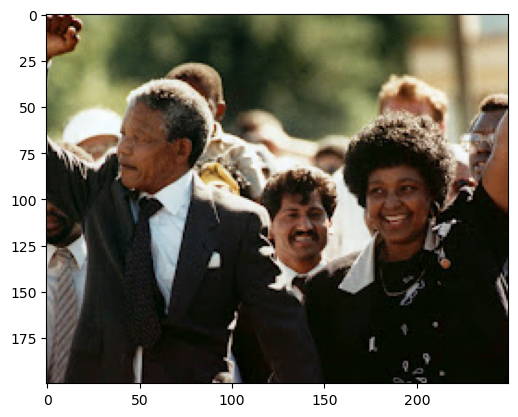

In [26]:
create_thumbnail('Nelson Mandela')

## Add Text to Thumbnail

In [35]:
# Sum of the min & max of (a, b, c)
def hilo(a, b, c):
    if c < b: b, c = c, b
    if b < a: a, b = b, a
    if c < b: b, c = c, b
    return a + c

def complement(r, g, b):
    k = hilo(r, g, b)
    return tuple(k - u for u in (r, g, b))

def add_thumbnail_text(image = 'thumbnail.png', font_choice = './Fonts/kalamaya-Regular.ttf',
                      font_size = 60, main_text = "", main_text_loc_x = 15,
                      main_text_loc_y = 15, subtitle_text = "10 Interesting Facts",
                      subtitle_font_size = 30, subtitle_loc_x = 15, subtitle_loc_y = 60, bw = False):
    
    # Add image as an object
    my_image = Image.open(image)
    
    # 1280 × 720 pixels - thumbnail size
    max_image_size = (1280, 720)

    # Set the image size to the max
    my_image.thumbnail(max_image_size)
    
    # Get the dominant colour of the image
    from colorthief import ColorThief
    color_thief = ColorThief(image)
    # get the dominant color
    dominant_color = color_thief.get_color(quality=1)

    # If the user says bw then colour will be black or white. This calc i saw to discover threshold
    if bw == True:
        luma = 0.2126 * dominant_color[0] + 0.7152 * dominant_color[1] + 0.0722 * dominant_color[2]
        if luma > 0.5:
            text_col = tuple([0, 0, 0])        # Black
        else:
            text_col = tuple([255, 255, 255])  # White
    else:
        # Use complementing colour
        text_col = complement(dominant_color[0],
                              dominant_color[1],
                              dominant_color[2])
    
    # Get the font for the title
    title_font = ImageFont.truetype(font_choice, font_size)
    # Get the text for the title
    title_text = main_text
    
    image_editable = ImageDraw.Draw(my_image)
    # ((starting_x, starting_y), text, (RGB colour), font)
    
    # miami vice - (248,144,231)
    image_editable.text((main_text_loc_x,main_text_loc_y),
                        title_text, text_col, font=title_font)
    
    # If there is subtitle text add that too
    if len(subtitle_text) > 0:
        title_font = ImageFont.truetype(font_choice, font_size - 20)
        title_text = "10 Interesting Facts"
        image_editable.text((subtitle_loc_x,subtitle_loc_y), title_text, text_col, font=title_font)
        
    return(my_image)


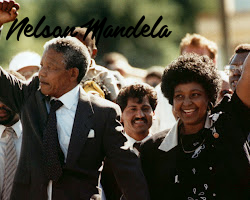

In [47]:
my_image = add_thumbnail_text(main_text="Nelson Mandela", bw = True,
                              subtitle_text="", main_text_loc_x= 5, font_size = 40)
my_image

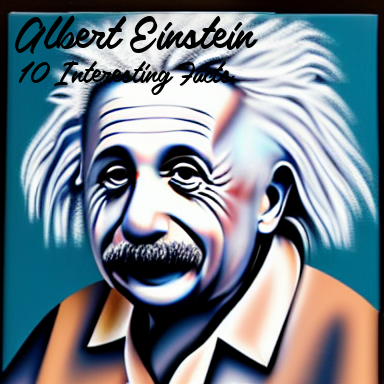

In [21]:
add_thumbnail_text(image="Einstein1.png", main_text="Albert Einstein", bw = True)

In [22]:
my_image.save("result.jpg")